In [1]:
import os
import struct
import sys
import warnings
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, '../../../')
import ldcpy

%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
warnings.filterwarnings("ignore")

# display the plots in this notebook
%matplotlib inline

os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/haiyingx/H5Z-ZFP-PLUGIN-unbiased/plugin'

In [2]:
def get_data(compression_type, daily_variables, compression_levels):
    data_path = "/glade/p/cisl/asap/CAM_lossy_test_data_31/research"

    climate_var_arrays = {}

    for variable in daily_variables:
        print(variable)

        new_levels = [f"orig_{variable}"]
        new_sets = [
            f"{data_path}/daily_orig/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
        ]

        for value in compression_levels:
            if compression_type == "ZFP":
                new_level = f"zfp_p_{value}_{variable}"
                new_set = f"{data_path}/daily_zfp_hdf5/zfp_p_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"
            elif compression_type == "BG":
                new_level = f"bg_{value}_{variable}"
                new_set = f"{data_path}/daily_bg/bg_{value}/b.e11.BRCP85C5CNBDRD.f09_g16.031.cam.h1.{variable}.20060101-20071231.nc"

            new_levels.append(new_level)
            new_sets.append(new_set)

        dataset = ldcpy.open_datasets("cam-fv", [f"{variable}"], new_sets, new_levels, chunks={})
        climate_var_arrays[variable] = np.array(dataset[variable].isel(time=0).values)

    return climate_var_arrays


def binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))


def get_adj_bit(bit_pos):
    return [bit_pos[0] - 1, bit_pos[1]]


def get_dict_list(data_array, x_index):
    dict_list_H = []
    for i in range(N_BITS - 1):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = binary(current_data)

            adj_data_index = get_adj_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = binary(adj_data)

            for i in range(N_BITS - 1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])

                p00 = p01 = p10 = p11 = 0
                if adjacent_bit == 0 and current_bit == 0:
                    p00 = 1
                elif adjacent_bit == 1 and current_bit == 0:
                    p10 = 1
                elif adjacent_bit == 0 and current_bit == 1:
                    p01 = 1
                elif adjacent_bit == 1 and current_bit == 1:
                    p11 = 1

                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11

    return dict_list_H


def get_mutual_info(p00, p01, p10, p11):
    p0 = p00 + p10  # current bit is 0
    p1 = p11 + p01  # current bit is 1
    p0_prev = p00 + p01  # prev bit was 0
    p1_prev = p11 + p10  # prev bit was 1

    # From (4) in paper
    mutual_info = 0
    if p00 > 0:
        mutual_info += p00 * np.log2(p00 / p0_prev / p0)
    if p11 > 0:
        mutual_info += p11 * np.log2(p11 / p1_prev / p1)
    if p01 > 0:
        mutual_info += p01 * np.log2(p01 / p0_prev / p1)
    if p10 > 0:
        mutual_info += p10 * np.log2(p10 / p1_prev / p0)

    return mutual_info


def get_real_info(data_array, x_index):
    dict_list_H = get_dict_list(data_array, x_index)

    # Total number of recordings. Sum all counts for first dictionary
    num_measurements = np.sum(list(dict_list_H[0].values()))

    mutual_info_array = []
    for bit_pos_dict in dict_list_H:
        p00 = np.divide(bit_pos_dict["00"], num_measurements, dtype=np.float64)
        p01 = np.divide(bit_pos_dict["01"], num_measurements, dtype=np.float64)
        p10 = np.divide(bit_pos_dict["10"], num_measurements, dtype=np.float64)
        p11 = np.divide(bit_pos_dict["11"], num_measurements, dtype=np.float64)

        mutual_info = get_mutual_info(p00, p01, p10, p11)

        mutual_info_array.append(mutual_info)

    mutual_info_array = np.array(mutual_info_array)
    return mutual_info_array

In [3]:
N_BITS = 32

# See here for a list of variables with more information:
# https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html
daily_variables = [
    "TS",
    "PRECT",
    "LHFLX",
    "FLNS",
    "ICEFRAC",
    "PSL",
    "Q200",
    "TAUX",
    "WSPDSRFAV",
    "Z500",
]

In [4]:
def get_bit_cutoff(climate_var_array, percent_info=0.999, lower_threshold=0.005):
    original_info = climate_var_array[0]
    original_info_copy = deepcopy(original_info)
    original_info_copy[original_info < lower_threshold] = 0

    original_info_sum = np.sum(original_info_copy)

    for bit_pos in range(N_BITS - 2):
        info_at_pos = np.sum(original_info_copy[0 : bit_pos + 1])
        info_ratio_at_pos = info_at_pos / original_info_sum
        if info_ratio_at_pos >= percent_info:
            return bit_pos
    return None


def get_compression_level(
    climate_var_array, cutoff_bit, area_threshold=0.057, lower_threshold=0.001
):
    if not cutoff_bit:
        return None

    cutoff_bit += 1

    original_info = climate_var_array[0]
    original_info_sum = np.sum(original_info)

    best_compression_idx = -1
    for compression_index in range(1, climate_var_array.shape[0]):
        compressed_info = climate_var_array[compression_index]
        compressed_info_copy = deepcopy(compressed_info)
        compressed_info_copy[cutoff_bit:] = 0

        area_diff = np.sum(np.abs(compressed_info_copy - original_info))
        area_percent = area_diff / original_info_sum

        if area_percent < area_threshold:
            best_compression_idx = compression_index

    if best_compression_idx == -1:
        return None

    return best_compression_idx


def get_real_info_all(climate_var_arrays):
    climate_var_arrays_dict = {}
    for daily_variable in daily_variables:
        information_array = []
        arr = climate_var_arrays[daily_variable]

        for i in range(arr.shape[0]):
            mutual_info = get_real_info(arr, i)
            information_array.append(mutual_info)

        climate_var_arrays_dict[daily_variable] = np.array(information_array)

    return climate_var_arrays_dict


def plot_real_info(climate_var_arrays_dict, compression_levels, comp_name, y_max=0.85):
    compression_levels = [comp_name + "_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels
    for daily_variable in daily_variables:
        arr = climate_var_arrays_dict[daily_variable]

        cutoff = get_bit_cutoff(arr)
        print("Cutoff bit:", cutoff)

        compression_level_idx = get_compression_level(arr, cutoff)
        if compression_level_idx:
            compression_level = compression_levels[compression_level_idx]
            print("Compression Level:", compression_level)
        else:
            print("Compression Level: None")

        is_original = True
        for mutual_info in arr:
            if is_original:
                plt.plot(mutual_info, linewidth=4)
                is_original = False
            else:
                plt.plot(mutual_info, "--")

        plt.ylim((0, y_max))
        plt.title(f"{comp_name}: {daily_variable}")
        plt.xlabel("Bit Position")
        plt.ylabel("Real Information")
        plt.legend(compression_levels)
        plt.show()

TS
dataset size in GB 1.62

PRECT
dataset size in GB 1.62

LHFLX
dataset size in GB 1.62

FLNS
dataset size in GB 1.62

ICEFRAC
dataset size in GB 1.62

PSL
dataset size in GB 1.62

Q200
dataset size in GB 1.62

TAUX
dataset size in GB 1.62

WSPDSRFAV
dataset size in GB 1.62

Z500
dataset size in GB 1.62

Cutoff bit: 16
Compression Level: ZFP_12


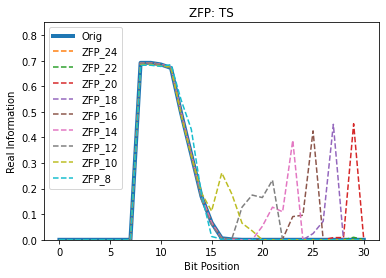

Cutoff bit: 7
Compression Level: None


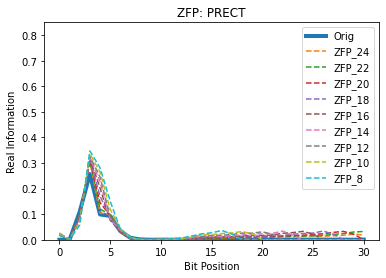

Cutoff bit: 9
Compression Level: ZFP_8


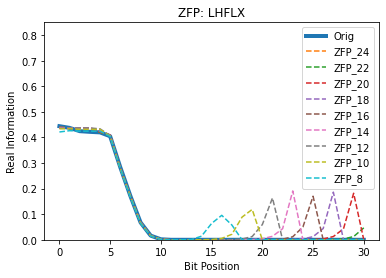

Cutoff bit: 10
Compression Level: ZFP_8


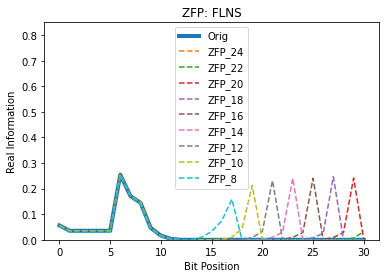

Cutoff bit: None
Compression Level: None


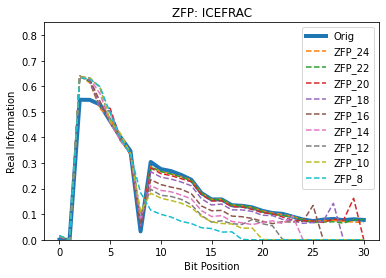

Cutoff bit: 17
Compression Level: ZFP_12


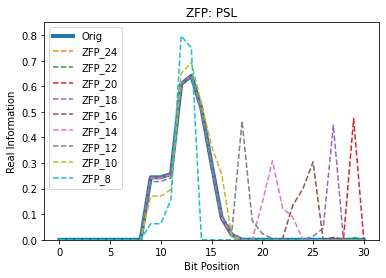

Cutoff bit: 11
Compression Level: ZFP_8


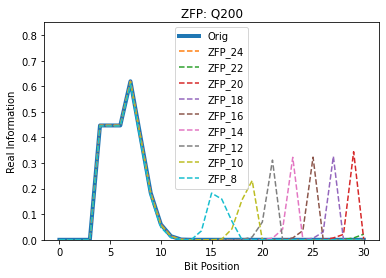

Cutoff bit: 8
Compression Level: ZFP_8


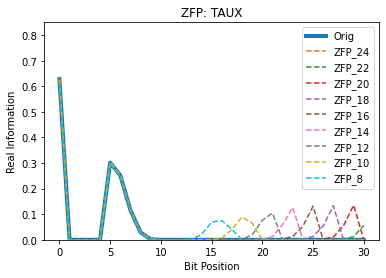

Cutoff bit: 10
Compression Level: ZFP_8


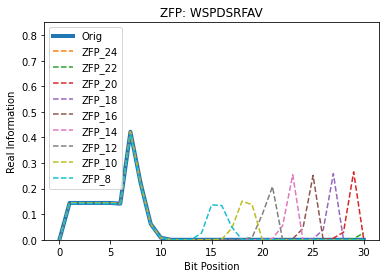

Cutoff bit: 17
Compression Level: ZFP_12


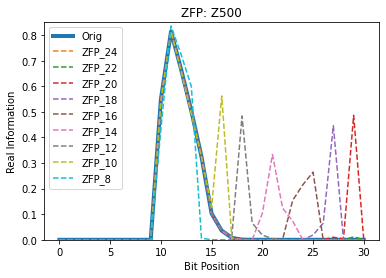

In [5]:
# ZFP
zfp_compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]

zfp_climate_var_arrays = get_data("ZFP", daily_variables, zfp_compression_levels)

zfp_climate_var_arrays_dict = get_real_info_all(zfp_climate_var_arrays)

plot_real_info(zfp_climate_var_arrays_dict, zfp_compression_levels, "ZFP")

TS
dataset size in GB 1.13

PRECT
dataset size in GB 1.13

LHFLX
dataset size in GB 1.13

FLNS
dataset size in GB 1.13

ICEFRAC
dataset size in GB 1.13

PSL
dataset size in GB 1.13

Q200
dataset size in GB 1.13

TAUX
dataset size in GB 1.13

WSPDSRFAV
dataset size in GB 1.13

Z500
dataset size in GB 1.13

Cutoff bit: 16
Compression Level: BG_3


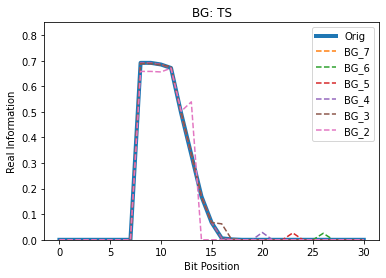

Cutoff bit: 7
Compression Level: BG_2


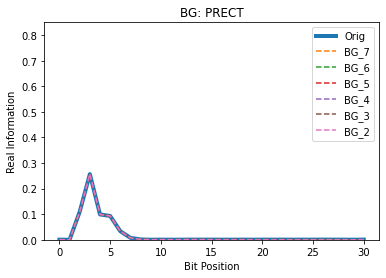

Cutoff bit: 9
Compression Level: BG_2


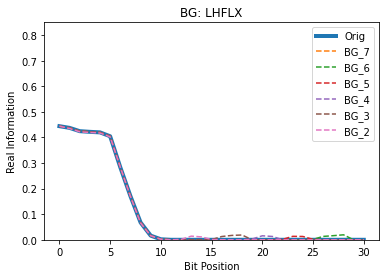

Cutoff bit: 10
Compression Level: BG_2


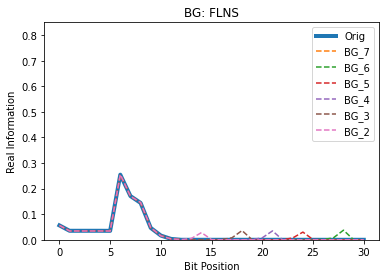

Cutoff bit: None
Compression Level: None


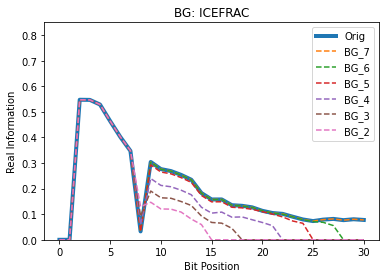

Cutoff bit: 17
Compression Level: BG_4


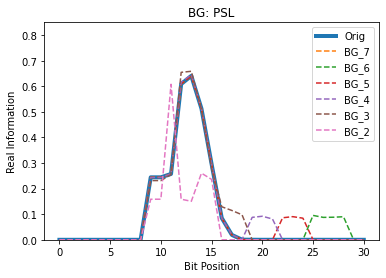

Cutoff bit: 11
Compression Level: BG_2


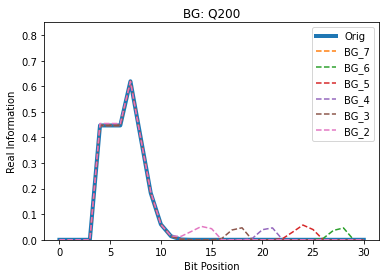

Cutoff bit: 8
Compression Level: BG_2


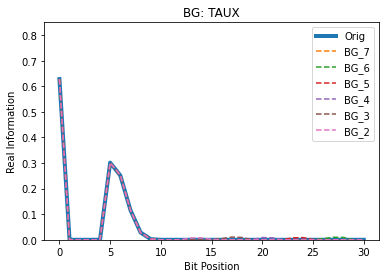

Cutoff bit: 10
Compression Level: BG_2


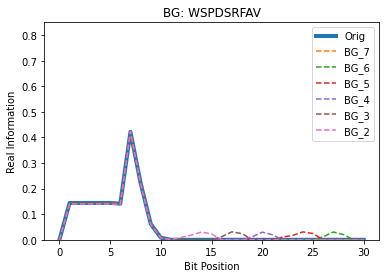

Cutoff bit: 17
Compression Level: BG_3


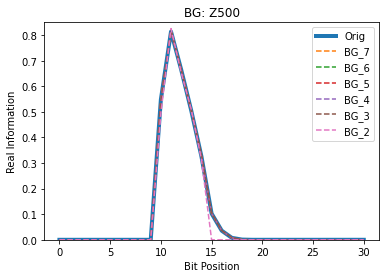

In [6]:
# BG
bg_compression_levels = [7, 6, 5, 4, 3, 2]

bg_climate_var_arrays = get_data("BG", daily_variables, bg_compression_levels)

bg_climate_var_arrays_dict = get_real_info_all(bg_climate_var_arrays)

plot_real_info(bg_climate_var_arrays_dict, bg_compression_levels, "BG")